In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import gaussian_kde

from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes
import seaborn as sns; sns.set(color_codes=True)
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in

In [2]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

# Buoy 44017

In [3]:
#read all files for the 44017 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017'
all_files = glob.glob(path + "/*.txt")

b44017_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wave_wind = b44017_wave_wind[(b44017_wave_wind.WVHT !=99) & (b44017_wave_wind.WVHT > 0.1) &  (b44017_wave_wind.WSPD > 0.1) &
                                    (b44017_wave_wind.WSPD !=99)]
b44017_wave_wind['u10'] = b44017_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(4.1/0.000097)))
b44017_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 01:00:00,8.0,1.02,8.332126
1,2005-01-01 02:00:00,8.5,1.19,8.852884
2,2005-01-01 03:00:00,9.1,1.29,9.477794
3,2005-01-01 04:00:00,9.4,1.39,9.790248
4,2005-01-01 05:00:00,10.0,1.52,10.415158
...,...,...,...,...
3199,2019-08-23 06:40:00,3.9,1.37,4.061912
3205,2019-08-23 07:40:00,4.0,1.36,4.166063
3211,2019-08-23 08:40:00,4.6,1.38,4.790973
3217,2019-08-23 09:40:00,3.5,1.31,3.645305


In [4]:
x = b44017_wave_wind['u10']
y = b44017_wave_wind['WVHT']

In [5]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [6]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.94040617, -0.04875722,  0.01179163])

In [7]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.49770722539600665
0.5341532321795164
0.04797145174690242


Text(0.5, 1.0, 'Buoy 44017')

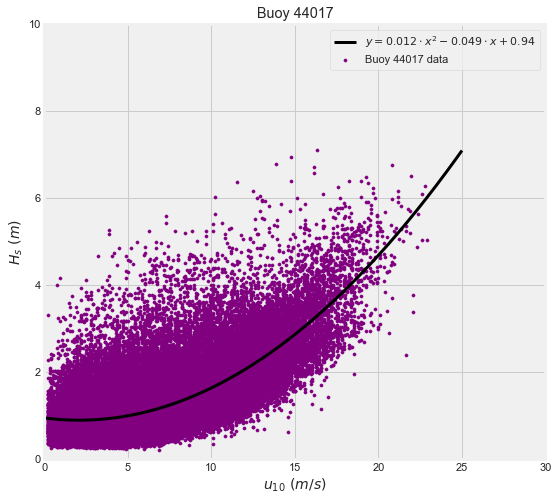

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44017 data')

ax.plot(xfit, yfit, color='black', linewidth=3, label=r'$y=0.012 \cdot x^2 - 0.049 \cdot x + 0.94 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44017')

# Buoy 44025

In [9]:
#read all files for the 44025 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44025'
all_files = glob.glob(path + "/*.txt")

b44025_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44025_wave_wind = b44025_wave_wind[(b44025_wave_wind.WVHT !=99) & (b44025_wave_wind.WVHT > 0.1) &  (b44025_wave_wind.WSPD > 0.1) &
                                    (b44025_wave_wind.WSPD !=99)]
b44025_wave_wind['u10'] = b44025_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(4.1/0.000097)))
b44025_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 00:00:00,9.0,0.87,9.373642
1,2005-01-01 01:00:00,9.3,1.00,9.686097
2,2005-01-01 02:00:00,8.9,1.27,9.269491
3,2005-01-01 03:00:00,9.8,1.42,10.206855
4,2005-01-01 04:00:00,10.2,1.60,10.623461
...,...,...,...,...
734,2020-03-31 18:50:00,5.7,2.02,5.936640
735,2020-03-31 19:50:00,5.2,1.79,5.415882
736,2020-03-31 20:50:00,5.2,1.91,5.415882
737,2020-03-31 21:50:00,5.3,1.78,5.520034


In [10]:
x = b44025_wave_wind['u10']
y = b44025_wave_wind['WVHT']

In [11]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit1 = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit1 = poly_model.predict(xfit[:, np.newaxis])

In [12]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.93053604, -0.04718166,  0.0113271 ])

In [13]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.5104193984630788
0.5123406597488956
0.05142476773830536


Text(0.5, 1.0, 'Buoy 44025')

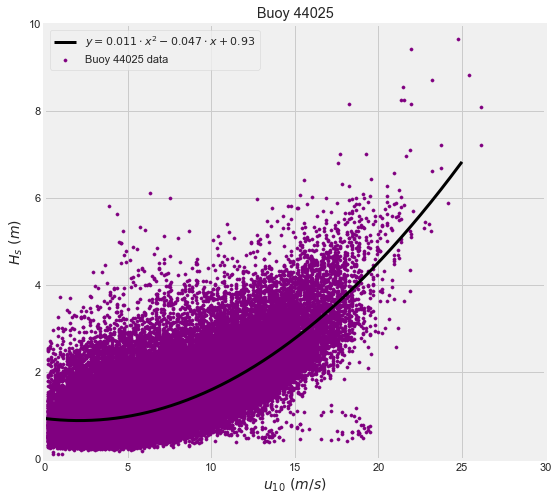

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44025 data')

ax.plot(xfit1, yfit1, color='black', linewidth=3, label=r'$y=0.011 \cdot x^2 - 0.047 \cdot x + 0.93 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44025')

# Buoy 44065

In [15]:
#read all files for the 44065 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44065'
all_files = glob.glob(path + "/*.txt")

b44065_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44065_wave_wind = b44065_wave_wind[(b44065_wave_wind.WVHT !=99) & (b44065_wave_wind.WVHT > 0.1) &  (b44065_wave_wind.WSPD > 0.1) &
                                    (b44065_wave_wind.WSPD !=99)]
b44065_wave_wind['u10'] = b44065_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(4.1/0.000097)))
b44065_wave_wind

,Date,WSPD,WVHT,u10
0,2008-10-30 17:50:00,8.2,0.67,8.540430
1,2008-10-30 18:50:00,8.3,0.54,8.644581
2,2008-10-30 19:50:00,7.1,0.56,7.394762
3,2008-10-30 20:50:00,8.1,0.61,8.436278
5,2008-10-30 22:50:00,7.9,0.61,8.227975
...,...,...,...,...
4380,2020-03-31 19:40:00,2.9,1.36,3.020396
4386,2020-03-31 20:40:00,3.5,1.45,3.645305
4392,2020-03-31 21:40:00,3.9,1.47,4.061912
4398,2020-03-31 22:40:00,4.7,1.44,4.895124


In [16]:
x = b44065_wave_wind['u10']
y = b44065_wave_wind['WVHT']

In [17]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit2 = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit2 = poly_model.predict(xfit[:, np.newaxis])

In [18]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.83425874, -0.04413746,  0.00890762])

In [19]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.37037995609745866
0.44432945750573166
0.037191425734501155


Text(0.5, 1.0, 'Buoy 44065')

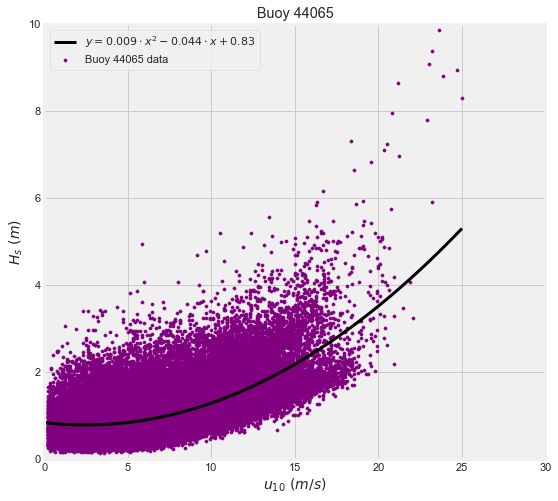

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44065 data')

ax.plot(xfit2, yfit2, color='black', linewidth=3, label=r'$y=0.009 \cdot x^2 - 0.044 \cdot x + 0.83 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44065')

# Buoy 44020

In [21]:
#read all files for the 44020 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44020'
all_files = glob.glob(path + "/*.txt")

b44020_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44020_wave_wind = b44020_wave_wind[(b44020_wave_wind.WVHT !=99) & (b44020_wave_wind.WVHT > 0.1) &  (b44020_wave_wind.WSPD > 0.1) &
                                    (b44020_wave_wind.WSPD !=99)]
b44020_wave_wind['u10'] = b44020_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(3.8/0.000097)))
b44020_wave_wind

,Date,WSPD,WVHT,u10
2,2009-03-10 15:50:00,2.5,0.61,2.622497
3,2009-03-10 16:50:00,2.6,0.68,2.727397
5,2009-03-10 18:50:00,3.9,0.52,4.091096
6,2009-03-10 19:50:00,4.5,0.44,4.720495
9,2009-03-10 22:50:00,5.2,0.37,5.454795
...,...,...,...,...
105,2020-03-03 13:40:00,3.0,0.28,3.146997
108,2020-03-03 14:40:00,4.1,0.29,4.300896
112,2020-03-03 17:40:00,5.3,0.34,5.559695
117,2020-03-03 20:40:00,5.0,0.33,5.244995


In [22]:
x = b44020_wave_wind['u10']
y = b44020_wave_wind['WVHT']

In [23]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit3 = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit3 = poly_model.predict(xfit[:, np.newaxis])

In [24]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.25490128, -0.01590646,  0.00645821])

In [25]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.8182553275332293
0.13995978365339534
0.00839300846848256


Text(0.5, 1.0, 'Buoy 44020')

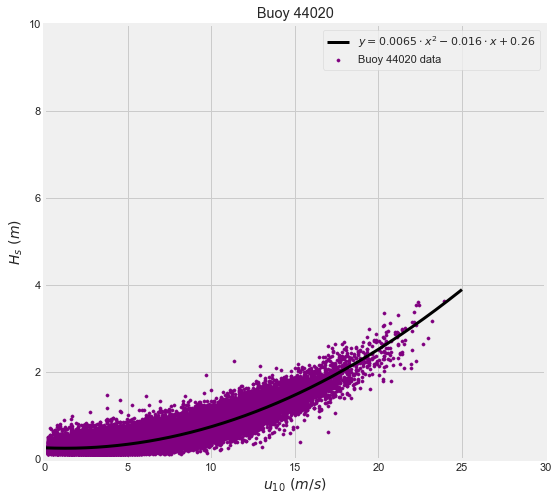

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44020 data')

ax.plot(xfit3, yfit3, color='black', linewidth=3, label=r'$y=0.0065 \cdot x^2 - 0.016 \cdot x + 0.26 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44020')

# Buoy 44039

In [27]:
#read all files for the 44039 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44039'
all_files = glob.glob(path + "/*.txt")

b44039_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44039_wave_wind = b44039_wave_wind[(b44039_wave_wind.WVHT !=99) & (b44039_wave_wind.WVHT > 0.1) &  (b44039_wave_wind.WSPD > 0.1) &
                                    (b44039_wave_wind.WSPD !=99)]
b44039_wave_wind['u10'] = b44039_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(3.5/0.000097)))
b44039_wave_wind

,Date,WSPD,WVHT,u10
0,2005-01-01 00:00:00,6.2,0.5,6.554764
1,2005-01-01 02:00:00,7.7,0.6,8.140594
2,2005-01-01 03:00:00,6.7,0.6,7.083374
3,2005-01-01 04:00:00,6.7,0.6,7.083374
4,2005-01-01 05:00:00,4.6,0.5,4.863212
...,...,...,...,...
244,2019-02-04 04:30:00,2.1,0.2,2.220162
245,2019-02-04 04:45:00,1.5,0.2,1.585830
360,2019-02-05 20:00:00,1.0,0.2,1.057220
0,2019-06-28 13:23:00,3.6,0.2,3.805992


In [28]:
x = b44039_wave_wind['u10']
y = b44039_wave_wind['WVHT']

In [29]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit4 = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit4 = poly_model.predict(xfit[:, np.newaxis])

In [30]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.19431655, -0.00230677,  0.00671357])

In [31]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.7613653785962248
0.17157397653934128
0.016583689415318386


Text(0.5, 1.0, 'Buoy 44039')

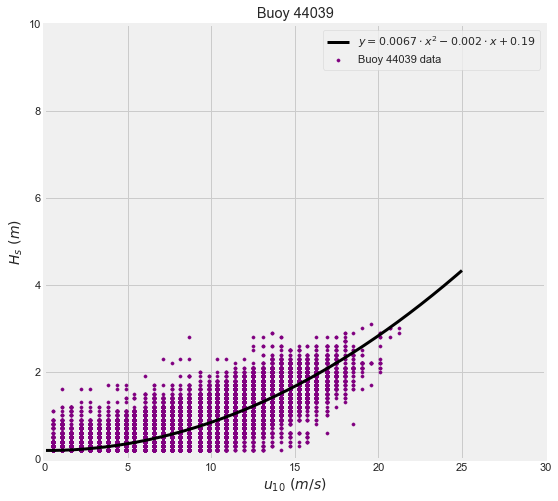

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44039 data')

ax.plot(xfit4, yfit4, color='black', linewidth=3, label=r'$y=0.0067 \cdot x^2 - 0.002 \cdot x + 0.19 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44039')

# Buoy 44040

In [33]:
#read all files for the 44040 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44040'
all_files = glob.glob(path + "/*.txt")

b44040_wave_wind = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44040_wave_wind = b44040_wave_wind[(b44040_wave_wind.WVHT !=99) & (b44040_wave_wind.WVHT > 0.1) &  (b44040_wave_wind.WSPD > 0.1) &
                                    (b44040_wave_wind.WSPD !=99)]
b44040_wave_wind['u10'] = b44040_wave_wind['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(3.5/0.000097)))
b44040_wave_wind

,Date,WSPD,WVHT,u10
1,2006-05-01 00:30:00,4.6,0.2,4.863212
3,2006-05-01 01:30:00,3.1,0.2,3.277382
5,2006-05-01 02:30:00,2.1,0.2,2.220162
7,2006-05-01 03:30:00,1.5,0.2,1.585830
9,2006-05-01 04:30:00,1.5,0.2,1.585830
...,...,...,...,...
1425,2020-03-31 20:45:00,3.6,0.3,3.805992
1426,2020-03-31 20:50:00,3.1,0.3,3.277382
1427,2020-03-31 21:45:00,3.1,0.2,3.277382
1428,2020-03-31 21:50:00,2.6,0.2,2.748772


In [34]:
x = b44040_wave_wind['u10']
y = b44040_wave_wind['WVHT']

In [35]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit5 = np.linspace(0, 25, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit5 = poly_model.predict(xfit[:, np.newaxis])

In [36]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.2741206 , -0.03601989,  0.00737262])

In [37]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

# R squared
print(np.mean(scores['test_r2']))

# RMSE mean
print(-np.mean(scores['test_neg_root_mean_squared_error']))

# RMSE std
print(np.std(scores['test_neg_root_mean_squared_error']))

0.5654244458972922
0.17725424397703354
0.014155464005517376


Text(0.5, 1.0, 'Buoy 44040')

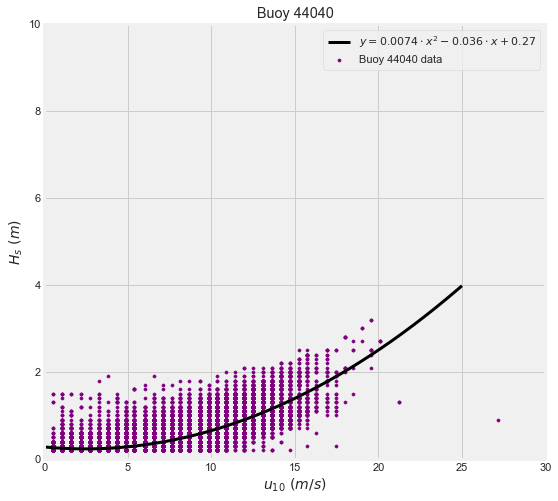

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44040 data')

ax.plot(xfit5, yfit5, color='black', linewidth=3, label=r'$y=0.0074 \cdot x^2 - 0.036 \cdot x + 0.27 $')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

plt.ylim(0,10)
plt.xlim(0,30)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')
#extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
#ax.legend([extra], [(r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_neg_root_mean_squared_error']),
                                                      #np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
plt.title('Buoy 44040')

## Buoy Wind-Wave Relationships Comparison

Text(0.5, 1.0, 'Buoy Wind Speed-Wave Height Relationships')

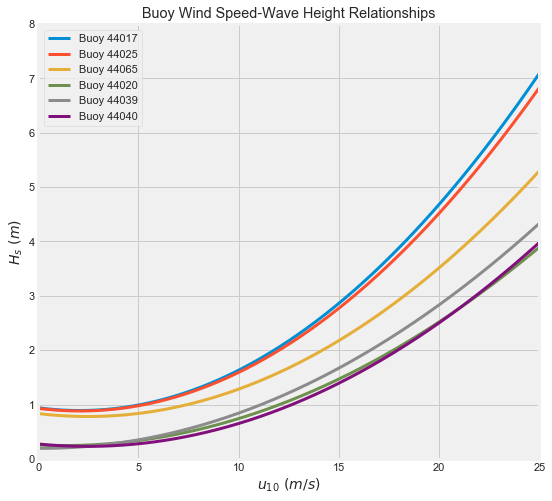

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(xfit, yfit, linewidth=3, label='Buoy 44017')
ax.plot(xfit1, yfit1, linewidth=3, label='Buoy 44025')
ax.plot(xfit2, yfit2, linewidth=3, label='Buoy 44065')
ax.plot(xfit3, yfit3, linewidth=3, label='Buoy 44020')
ax.plot(xfit4, yfit4, linewidth=3, label='Buoy 44039')
ax.plot(xfit5, yfit5, linewidth=3, label='Buoy 44040')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$", ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

plt.xlim(0,25)
plt.ylim(0,8)

plt.title('Buoy Wind Speed-Wave Height Relationships')

## Buoys Location

In [40]:
def make_map(projection=ccrs.LambertConformal()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [41]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="C:E")
for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):print(x,y,z)

-71.127 40.969 44097
-70.279 41.493 44020
-73.164 40.251 44025
-72.049 40.693 44017
-73.703 40.369 44065
-72.655 41.138 44039
-73.58 40.956 44040
-71.033 41.397 BUZM3


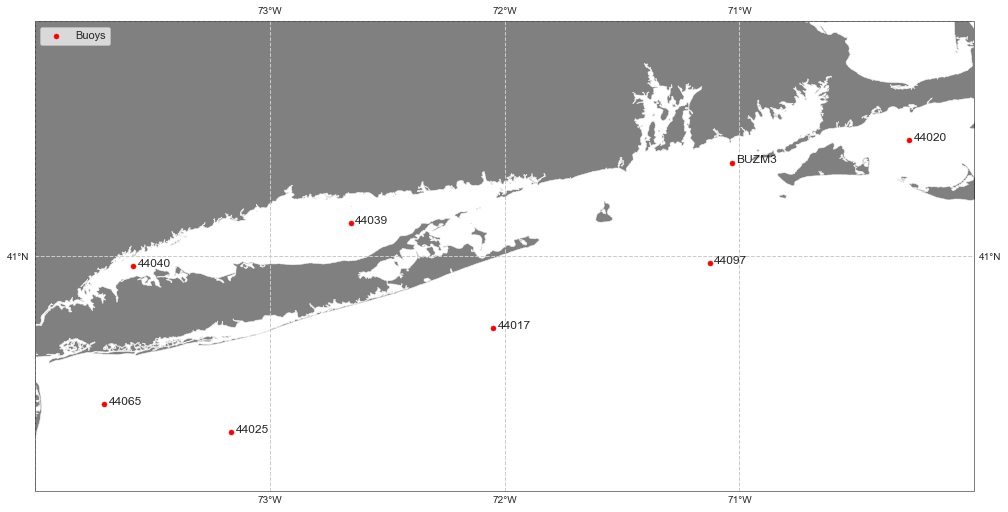

In [42]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

# Add markers for the position of the buoys.
plt.scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='o', color='red', label='Buoys',
            transform=ccrs.Geodetic())

for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):
    ax.text(x+0.02, y+0.01, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=12,
                 transform=ccrs.Geodetic())

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')
     
ax.legend(loc='upper left')